# Airbnb Pricing Predictor
- A statistical model built to predict the price of an AirBnB given listing information (i.e. neighbourhood, apartment type, room characteristics, etc.) in 'NYC', 'LA', 'DC', 'Boston', 'SF', 'Chicago'.

- This notebook contains examples running regression estimations on the AirBnB dataset. Our target variable is price($USD) of the listing.

We can sketch out the process as follows:
* [1. Define the problem](#first-bullet)
* [2. Obtain the Data](#second-bullet)
* [3. Data Cleaning](#third-bullet)
* [4. Exploratory Data Analysis](#four-bullet)
* [5. Model the data](#fifth-bullet)
* [6. Conclusion](#sixth-bullet)

## 1. Define the Problem  <a class="anchor" id="first-bullet"></a>

Based on this dataset, we are running examples of regression estimations on the AirBnB listings from six cities ('NYC', 'LA', 'DC', 'Boston', 'SF', 'Chicago') to predict the price of other AirBnBs, given the same listing information.

## 2. Obtain the Data  <a class="anchor" id="second-bullet"></a>

In [1]:
# import libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, typically you would leave them on

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV, ElasticNetCV, RANSACRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer

from sklearn_pandas import DataFrameMapper, CategoricalImputer

from sklearn.metrics import confusion_matrix
import sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv('data/train.csv')

In [5]:
# set to display all columns
pd.set_option('display.max_columns', 500)
data.head()

,id,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price
0,46730,Apartment,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,flexible,False,NYC,Квартира рядом с метро ( 3мин пешком) 4 станци...,t,f,NaN,2016-12-14,t,40.577507,-73.985210,"Не дорогая комната в Нью-Йорке, в Бруклине",Coney Island,1,100.0,11224.0,1.0,1.0,50.0
1,48393,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,3.0,Real Bed,moderate,True,LA,"Spacious, bright penthouse loft Condo in Brent...",t,f,NaN,2016-02-27,f,34.047200,-118.465782,Penthouse Loft Condo in Brentwood,Brentwood,2,100.0,90049,1.0,1.0,200.0
2,41416,Apartment,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,2.0,Real Bed,flexible,False,NYC,"Washington Heights. Brand new renovated, dark ...",t,t,70%,2012-03-05,f,40.853085,-73.928880,French Night in NYC,Washington Heights,0,NaN,10040,3.0,1.0,45.0
3,34506,Apartment,Entire home/apt,"{""Wireless Internet"",Kitchen,""Family/kid frien...",4,1.0,Real Bed,moderate,True,NYC,Brownstone apartment in Harlem. Very quiet blo...,t,f,100%,2017-07-31,f,40.807185,-73.949837,Harlem brownstone apartment,Harlem,2,100.0,10027,2.0,3.0,130.0
4,43725,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,Real Bed,strict,True,DC,Welcome to my flat in DC! About the apartmen...,t,f,50%,2011-05-22,f,38.900307,-77.016468,"""The Family"" Flat Downtown DC- 1023",Judiciary Square,102,95.0,20001,1.0,1.0,215.0


In [6]:
# drop ID column, not 
data = data.drop('id', axis=1)

## 3. Data Cleaning <a class="anchor" id="third-bullet"></a>

To check for proper formats, incorrect entries, etc.
1. We will drop any entries that are missing (NaN) values (except for review_scores_rating due to the large number).
2. We also drop any entries that are inconsistent; i.e. predictors accommodates, bedrooms, beds, or price with a value of 0.
3. Convert ZipCode values to be 5 digits; i.e. 4123 --> 04123 or 10022-4175 --> 10022

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
property_type             50000 non-null object
room_type                 50000 non-null object
amenities                 50000 non-null object
accommodates              50000 non-null int64
bathrooms                 49875 non-null float64
bed_type                  50000 non-null object
cancellation_policy       50000 non-null object
cleaning_fee              50000 non-null bool
city                      50000 non-null object
description               50000 non-null object
host_has_profile_pic      49877 non-null object
host_identity_verified    49877 non-null object
host_response_rate        37637 non-null object
host_since                49877 non-null object
instant_bookable          50000 non-null object
latitude                  50000 non-null float64
longitude                 50000 non-null float64
name                      50000 non-null object
neighbourhood             4

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,50000.0,3.151780,2.170373,1.000000,2.000000,2.000000,4.000000,16.000000
bathrooms,49875.0,1.233464,0.584081,0.000000,1.000000,1.000000,1.000000,8.000000
latitude,50000.0,38.453568,3.079660,33.338905,34.127573,40.662752,40.746226,42.390248
longitude,50000.0,-92.388038,21.709764,-122.510940,-118.342612,-76.996397,-73.954355,-70.985047
number_of_reviews,50000.0,21.080140,38.113959,0.000000,1.000000,6.000000,24.000000,605.000000
review_scores_rating,38729.0,94.053035,7.932111,20.000000,92.000000,96.000000,100.000000,100.000000
bedrooms,49945.0,1.264631,0.859241,0.000000,1.000000,1.000000,1.000000,10.000000
beds,49927.0,1.709536,1.266431,0.000000,1.000000,1.000000,2.000000,18.000000
price,50000.0,159.502500,167.605699,1.000000,74.000000,110.000000,184.000000,1999.000000


In [9]:
# It appears that we have some values that are out of place -
# airbnb's with 0 bedrooms, 0 beds, 0 bathrooms and price of $1, 
# which is highly improbable. 

In [10]:
# convert 'host_response_rate' to float out of 1
data['host_response_rate'] = data['host_response_rate'].str.strip('%').astype(float)/100

In [11]:
# convert 'review_scores_rating' to float out of 1
data['review_scores_rating'] = data['review_scores_rating']/100

In [12]:
data.head()

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price
0,Apartment,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,flexible,False,NYC,Квартира рядом с метро ( 3мин пешком) 4 станци...,t,f,NaN,2016-12-14,t,40.577507,-73.985210,"Не дорогая комната в Нью-Йорке, в Бруклине",Coney Island,1,1.00,11224.0,1.0,1.0,50.0
1,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,3.0,Real Bed,moderate,True,LA,"Spacious, bright penthouse loft Condo in Brent...",t,f,NaN,2016-02-27,f,34.047200,-118.465782,Penthouse Loft Condo in Brentwood,Brentwood,2,1.00,90049,1.0,1.0,200.0
2,Apartment,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,2.0,Real Bed,flexible,False,NYC,"Washington Heights. Brand new renovated, dark ...",t,t,0.7,2012-03-05,f,40.853085,-73.928880,French Night in NYC,Washington Heights,0,NaN,10040,3.0,1.0,45.0
3,Apartment,Entire home/apt,"{""Wireless Internet"",Kitchen,""Family/kid frien...",4,1.0,Real Bed,moderate,True,NYC,Brownstone apartment in Harlem. Very quiet blo...,t,f,1.0,2017-07-31,f,40.807185,-73.949837,Harlem brownstone apartment,Harlem,2,1.00,10027,2.0,3.0,130.0
4,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,Real Bed,strict,True,DC,Welcome to my flat in DC! About the apartmen...,t,f,0.5,2011-05-22,f,38.900307,-77.016468,"""The Family"" Flat Downtown DC- 1023",Judiciary Square,102,0.95,20001,1.0,1.0,215.0


## 4. Exploratory Data Analysis <a class="anchor" id="fourth-bullet"></a>

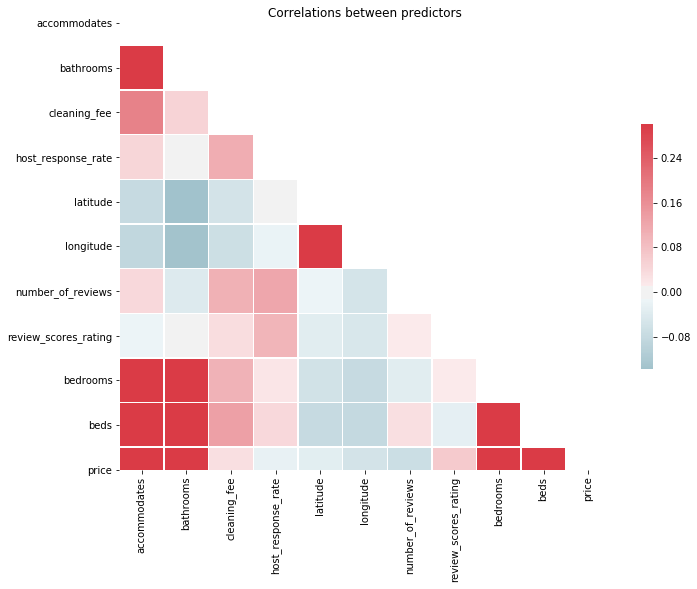

In [13]:
corr_df = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between predictors')
plt.show()

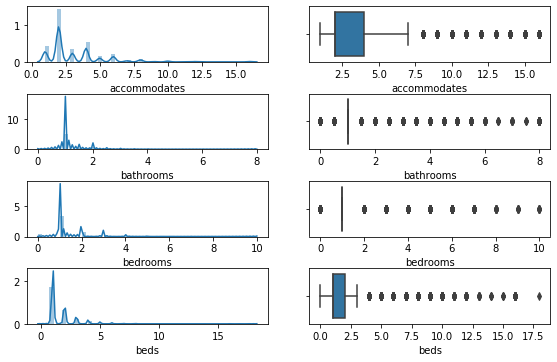

In [14]:
# plots of accomodates, bathrooms, bedrooms and beds
cols = ['accommodates','bathrooms', 'bedrooms', 'beds']
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(8,5))
fig.tight_layout()
for i in range(len(cols)):
    data_plot = data.dropna(subset = [cols[i]])
    sns.distplot(data_plot[cols[i]], ax=axes[i,0])
    sns.boxplot(data_plot[cols[i]], ax=axes[i,1])
fig.show()

In [15]:
# Determine missing entries in each column
data.isnull().sum()

property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   125
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
host_has_profile_pic        123
host_identity_verified      123
host_response_rate        12363
host_since                  123
instant_bookable              0
latitude                      0
longitude                     0
name                          0
neighbourhood              4569
number_of_reviews             0
review_scores_rating      11271
zipcode                     624
bedrooms                     55
beds                         73
price                         0
dtype: int64

In [16]:
# We can observe a significant number of nulls in host_response_rate and
# review_scores_rating. As this will have a high probability of skewing
# our model, we will be dropping these columns in the DataFrameMapper later
# on.

In [17]:
# check categorical features (objects)
#data.select_dtypes(include =['object'])

def check_categorial(col_name):
    print('\n' + col_name)
    print(data[col_name].value_counts())
    
# Analyse types of each categorial features
for col in data.columns[data.dtypes == 'object']:
    check_categorial(col)


property_type
Apartment             33042
House                 11209
Condominium            1755
Townhouse              1172
Loft                    826
Other                   396
Guesthouse              329
Bed & Breakfast         305
Bungalow                246
Villa                   123
Dorm                     98
Guest suite              87
Camper/RV                64
Cabin                    50
Boutique hotel           49
In-law                   48
Hostel                   46
Timeshare                44
Boat                     41
Serviced apartment       15
Tent                     10
Yurt                      8
Castle                    8
Treehouse                 5
Vacation home             5
Earth House               4
Hut                       4
Tipi                      3
Chalet                    3
Cave                      2
Lighthouse                1
Train                     1
Island                    1
Name: property_type, dtype: int64

room_type
Entire home/apt 

In [18]:
target = 'price'
X = data.drop(target, axis=1)
y = data[target]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### Preprocessing 
Using StandardScaler, LabelBinarizer, SimpleImputer, Categorical Imputer.

In [20]:
# Grab all column names
# pd.DataFrame(data.dtypes).sort_values(0).to_dict()[0]

In [21]:
# Excluding columns ID, Longitude, Latitude, zipcode (information is captured
# in city), Description, Name (both are subjective categories)

In [22]:
# some columns are # out to play around with the regressors
mapper = DataFrameMapper ([
   ('cleaning_fee',[CategoricalImputer(), LabelBinarizer()]),
   (['number_of_reviews'], [SimpleImputer(),PolynomialFeatures(degree =5, include_bias=False),StandardScaler()]),
   (['accommodates'], [SimpleImputer(strategy='most_frequent'),PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   (['bedrooms'], [SimpleImputer(strategy='median'),PolynomialFeatures(degree =5,include_bias=False), StandardScaler()]),
   (['beds'], [SimpleImputer(strategy='median'), PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   (['bathrooms'], [SimpleImputer(strategy='median'), PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   ('host_has_profile_pic', [CategoricalImputer(), LabelBinarizer()]),
   ('cancellation_policy', [CategoricalImputer(), LabelBinarizer()]),
#   ('host_since', [CategoricalImputer(), LabelBinarizer()]),
   ('instant_bookable', [CategoricalImputer(), LabelBinarizer()]),
   ('bed_type', [CategoricalImputer(), LabelBinarizer()]),
#   ('neighbourhood', [CategoricalImputer(), LabelBinarizer()]),
#   ('amenities', [LabelBinarizer()]),
   ('room_type', [CategoricalImputer(), LabelBinarizer()]),
   ('property_type', [CategoricalImputer(), LabelBinarizer()]),
   ('city', [CategoricalImputer(), LabelBinarizer()]),
   ('host_identity_verified', [CategoricalImputer(), LabelBinarizer()])
   ], df_out=True
 )

In [23]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

## 5. Model the data <a class="anchor" id="fifth-bullet"></a>

In [24]:
# Linear Regression
model = LinearRegression().fit(Z_train, y_train)
model.score(Z_train, y_train)

0.4451535260596208

In [25]:
model.score(Z_test, y_test)

0.44776147993762283

In [26]:
model.predict(Z_train)

array([296.8031417 ,  84.97826583, 157.19136719, ..., 158.66156183,
       106.67992895,  80.99648271])

In [27]:
# LASSO
# Set up a list of LASSO alphas to check.
l_alphas = np.linspace(0, 5, 200)

# Cross-validate over our list of Lasso alphas.
lasso = LassoCV(alphas=l_alphas, cv=10, verbose=1)
lasso.fit(Z_train, y_train)
lasso_alpha = lasso.alpha_
print(lasso_alpha)
# Fit model using best lasso alpha!

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0


In [28]:
# Instantiate LASSO model.
lasso_opt = Lasso(alpha=lasso_alpha)

lasso_scores = cross_val_score(lasso_opt, Z_train, y_train, cv=10)

In [29]:
lasso_opt.fit(Z_train, y_train)

Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
lasso_opt.score(Z_train, y_train)

0.44298918170285684

In [31]:
lasso_opt.score(Z_test, y_test)

0.4511125755386419

In [32]:
lasso_opt.predict(Z_train)

array([295.51164675,  80.05328724, 151.62251331, ..., 168.11935591,
       105.38788733,  87.95072392])

In [33]:
# RANSAC Regressor
reg = RANSACRegressor(random_state=42).fit(Z_train, y_train)

In [34]:
reg.score(Z_train, y_train)

-3296034447782.2314

In [35]:
reg.predict(Z_train)

array([263.94677734,  85.86669922, 200.23681641, ..., 170.32958984,
        97.83056641,  67.40087891])

In [36]:
# To predict prices for 'test' data set and submit to Kaggle
df_submit = pd.read_csv('data/test.csv')

In [37]:
Z_submit = mapper.transform(df_submit)

In [38]:
Z_submit.isnull().sum()

cleaning_fee              0
number_of_reviews_x0      0
number_of_reviews_x0^2    0
number_of_reviews_x0^3    0
number_of_reviews_x0^4    0
                         ..
city_DC                   0
city_LA                   0
city_NYC                  0
city_SF                   0
host_identity_verified    0
Length: 81, dtype: int64

In [39]:
# Using LASSO as an example and add in price column
df_submit['price'] = lasso_opt.predict(Z_submit) 
df_submit

,id,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price
0,54473,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,1.0,Real Bed,moderate,True,DC,Come stay in DC's most beautiful neighborhood ...,t,t,100%,2009-01-31,f,38.880847,-76.996590,"Bright 1BR, walk to Metro!",NaN,1,100.0,20003,1.0,1.0,168.447022
1,9950,Apartment,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,Real Bed,strict,True,LA,HIGH RISE TOWER APT: Private bed/bath within 2...,t,t,100%,2014-04-03,f,34.066117,-118.348578,"Luxurious Heart of LA,Private RM/BA",Mid-Wilshire,44,97.0,90036,1.0,2.0,64.625891
2,50751,Apartment,Private room,"{Internet,""Wireless Internet"",Kitchen,Washer,D...",2,1.0,Real Bed,flexible,True,LA,The room has a queen size bed and has a privat...,t,f,NaN,2016-02-27,f,34.051275,-118.371369,Beautiful Room in Los Angeles,Mid-Wilshire,1,NaN,90035,1.0,1.0,70.657510
3,22699,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",4,1.0,Real Bed,flexible,False,LA,Comfortable. Hip. Modern. Loft in Downtown LA....,t,f,50%,2016-08-13,t,34.047381,-118.248254,Hip. Comfortable. Modern. LOFT,NaN,0,NaN,90013,1.0,2.0,185.084496
4,11075,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",3,1.0,Real Bed,moderate,True,NYC,A great little Studio that is near everything....,t,f,100%,2016-02-29,f,40.810318,-73.954146,Comfy NYC Studio 15 Min. To Midtown,Harlem,87,90.0,10027,0.0,2.0,117.939244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,37194,Apartment,Private room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.5,Real Bed,strict,True,LA,Private Rm w/Priv Half-Bath in addition to Sha...,t,f,71%,2012-06-04,f,34.094867,-118.292013,"✿ܓBEAUTFL PRIV #4+PRIVATE 1/2 BA, SHARED FULL ...",East Hollywood,1,100.0,90029,1.0,1.0,85.491888
19996,6265,House,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,1.0,Real Bed,flexible,True,LA,"Lovely room with full/queen bed, shared bath, ...",t,f,100%,2012-08-04,f,34.150509,-118.787469,Lovely room with a view,NaN,2,90.0,91301,1.0,1.0,54.107594
19997,54886,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5,2.0,Real Bed,strict,True,LA,Spanish style in prime Hollywood. Walking dist...,t,t,95%,2012-06-07,f,34.087073,-118.336914,Amazing 2 bed & 2 bath Melrose dist,Hollywood,20,91.0,90038,2.0,2.0,240.209114
19998,860,Apartment,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,strict,True,NYC,Prime location charming private room + shared ...,t,t,100%,2011-03-03,f,40.771579,-73.957856,Prime location private room in furnished ap 3b...,Upper East Side,0,NaN,10021,1.0,1.0,89.086157


In [40]:
# output to CSV
df_submit[['id', 'price']].to_csv('AT-2019-12-15-2.csv', index=False)

## 6. Conclusion <a class="anchor" id="sixth-bullet"></a>

In [41]:
# Lasso looks to be the better model for this data. This is due to
# the regressor's ability to identify columns that do not heavily
# affect predictions and to drop those columns entirely in the model.